# Coursework E


# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

import tensorflow as tf
from tensorflow import keras

In [4]:
#ivp functions

def rhs(t,z,L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2

def extract_data(z):
  'Extracts cartesian data from z'
  theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
  x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
  return(x1,x2,y1,y2)


#Part 1

In [5]:
#Initial conditions

#Length and mass
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

#Starting angles
z0=[np.pi/4,0,np.pi/4,0] # theta 1, w1, theta 2, w2

#Solve ivp)
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
x1,x2,y1,y2 = extract_data(z)
data = np.array([x1,x2,y1,y2])

In [39]:
#Define model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(20,input_shape=(None,4),return_sequences=False)) # LSTM layer 20 nodes
model.add(keras.layers.Dense(5,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20)                2000      
                                                                 
 dense_8 (Dense)             (None, 5)                 105       
                                                                 
Total params: 2105 (8.22 KB)
Trainable params: 2105 (8.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
#This function splits up a 1-d array x into a series of overlapping windows
#The return is a tuple of the array of input windows and target (label) windows
def shapeArray(x,windowsize,offset):
  xInput = np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
  xLabel = np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
  return (xInput,xLabel)

def modelparams(data,windowsize,offset):
  'Takes in data points and returns training and validation params for given windowsizer and offset'

  #Split data intro training and validation parts
  split = int(len(data[0])*0.7)

  train_data = np.array([data[0][0:split],data[1][0:split], data[2][0:split], data[3][0:split]]).T
  test_data = np.array([data[0][split:],data[1][split:],data[2][split:],data[3][split:]]).T

  #Shape test and training arrays
  train_dataInput,train_dataLabel = shapeArray(train_data,windowsize,offset)
  test_dataInput,test_dataLabel = shapeArray(test_data,windowsize,offset)

  # Get target data
  train_data_target = train_dataLabel[:, -1].reshape(train_dataLabel.shape[0], 4)
  test_data_target = test_dataLabel[:, -1].reshape(test_dataLabel.shape[0], 4)

  return(train_dataInput,train_data_target,test_dataInput,test_data_target)

In [41]:
#Train model
params =  modelparams(data,10,20)
print(params[0].shape)
print(params[1].shape)
print(params[3].shape)

history = model.fit(params[0],params[1],batch_size=20,epochs=200,verbose = 1,validation_data=(params[2], params[3]))

(321, 10, 4)
(321, 4)
(122, 4)
Epoch 1/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0242 - val_loss: 0.0209
Epoch 2/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0206 - val_loss: 0.0185
Epoch 3/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0187 - val_loss: 0.0169
Epoch 4/200
17/17 [==============================] - 0s 9ms/step - loss: 0.0172 - val_loss: 0.0153
Epoch 5/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 6/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 7/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 8/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0148 - val_loss: 0.0135
Epoch 9/200
17/17 [==============================] - 0s 8ms/step - loss: 0.0144 - val_loss: 0.0131
Epoch 10/200
17/17 [==============================] - 0s 10ms/step - loss: 0.0

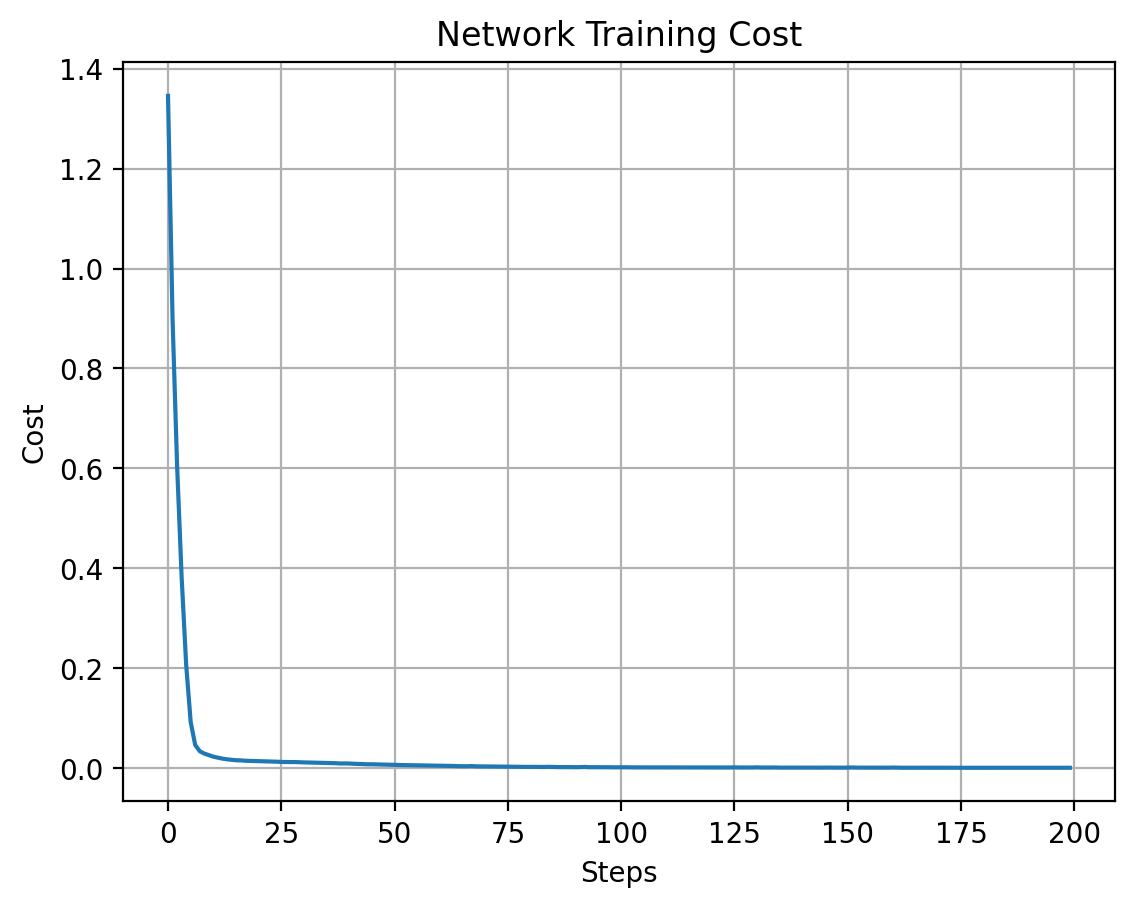

In [ ]:
#Plot costs vs steps
steps = 200
fig,ax=plt.subplots()
ax.plot(np.arange(steps),history.history["loss"],label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
plt.grid(True)

#Part 2

4/4 [==============================] - 1s 4ms/step


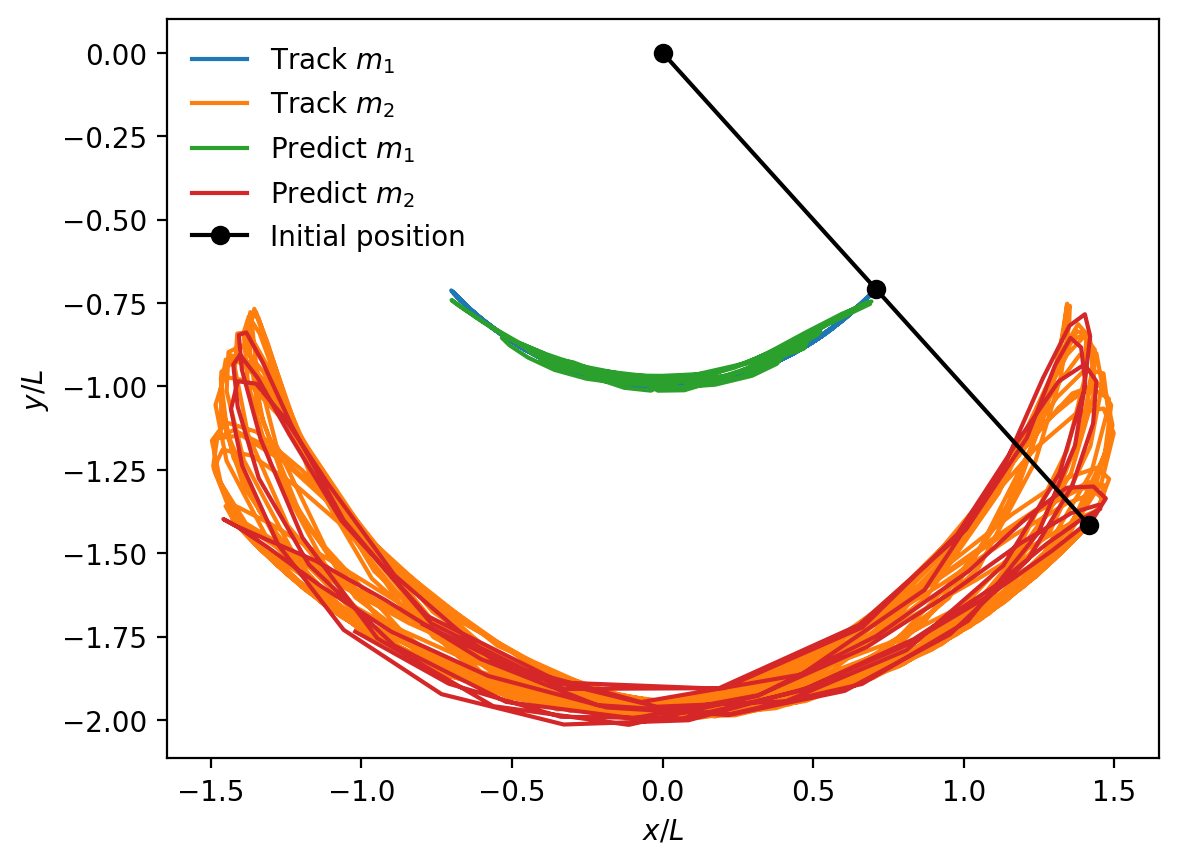

In [ ]:
#Plot predictive data over test range
def prediction_data(test_data,model):
  #Makes a prediction over test data
  predictions = model.predict(test_data)
  px1 = predictions[:,0]
  px2 = predictions[:,1]
  py1 = predictions[:,2]
  py2 = predictions[:,3]

  return(px1,px2,py1,py2)

px1,px2,py1,py2 = prediction_data(params[2],model)

# Plot the actual and predicted values
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")

ax.plot(px1, py1, label=r"Predict $m_1$")
ax.plot(px2, py2, label=r"Predict $m_2$")

ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [ ]:
# Variation of initial conditions
thetavals = np.linspace(0,np.pi/2,50)

def Netvar(thetavals,model):
  costs = []
  for i in thetavals:
    #Starting angles
    z0=[i,0,i,0] # theta 1, w1, theta 2, w2

    #Solve ivp)
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y

    # Extract result
    x1,x2,y1,y2 = extract_data(z)
    data = np.array([x1,x2,y1,y2])

    params =  modelparams(data,10,20)
    cost = model.evaluate(params[0],params[1])
    costs.append(cost)
  return(costs)

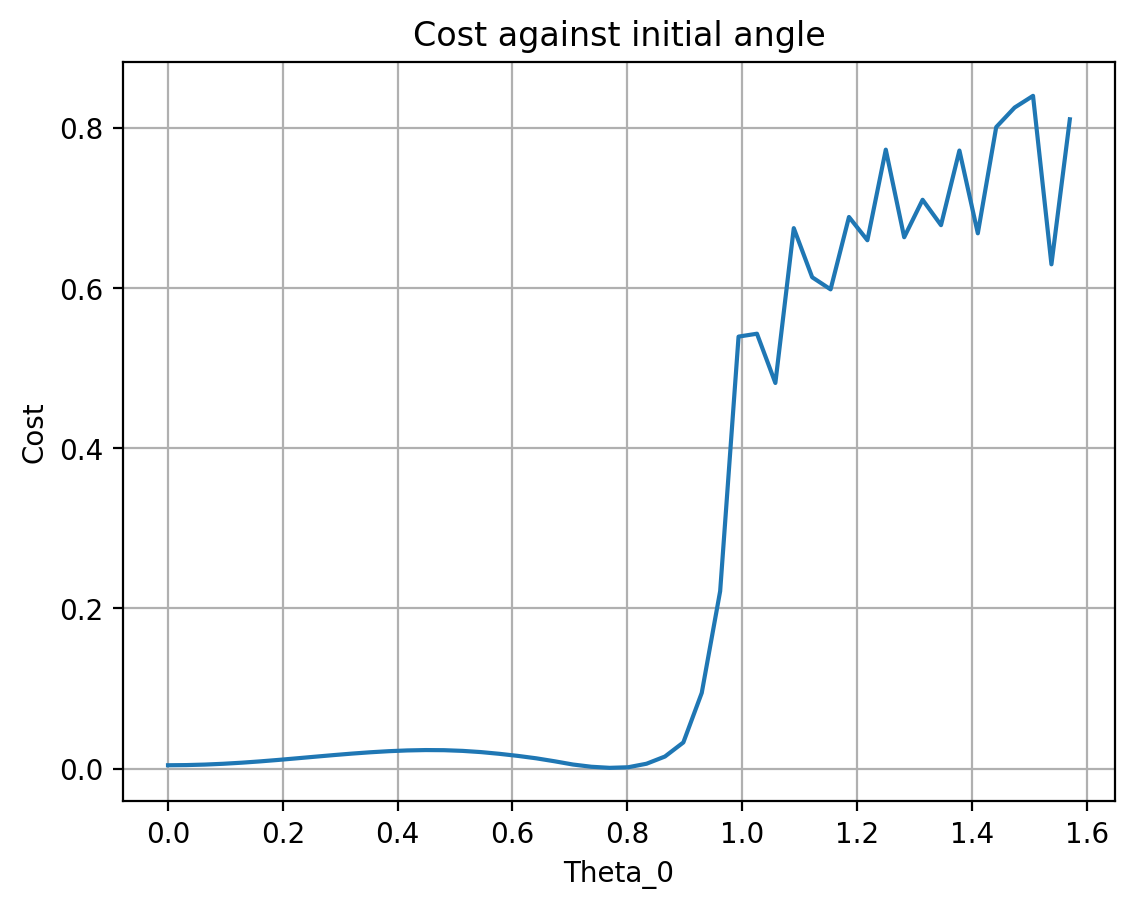

In [ ]:
#plot variation
costs = Netvar(thetavals,model)

fig,ax=plt.subplots()
ax.plot(np.linspace(0,max(thetavals),len(thetavals)),costs)
ax.set_xlabel("Theta_0")
ax.set_ylabel("Cost")
ax.set_title("Cost against initial angle")
plt.grid(True)

#Part 3

In [ ]:
def OffsetsPlotCost(data,offsets,modell):
  'Retrains and plots prediction and ivp data components over test range for series of offsets. returns minimum cost point for each offset'

  #Setup trackers
  index = 0
  test_costs = []

  #Setup subplots
  fig, axs = plt.subplots(nrows = 5,ncols = 4,figsize = (20,20))
  plt.subplots_adjust(hspace=0.5)
  plt.subplots_adjust(wspace=1)

  figs = ((0,0),(0,1),(0,2),(0,3),
        (1,0),(1,1),(1,2),(1,3),
        (2,0),(2,1),(2,2),(2,3),
        (3,0),(3,1),(3,2),(3,3)
        ,(4,0))

  for i in offsets:

    ##### Reset and train model
    model=modell
    params =  modelparams(data,10,offsets[index]) #Windowsize 10
    history = model.fit(params[0],params[1],batch_size=20,epochs=200,verbose = 0,validation_data=(params[2], params[3]))

    ##### Plot difference betwen predictive data against ivp soultion
    px1,px2,py1,py2 = prediction_data(params[2],modell)

    print(figs[0])
    # Plot the actual vs predicted values
    axs[figs[index]].plot(t[-len(px1):],x1[-len(px1):],label=('ivp x1'))
    axs[figs[index]].plot(t[-len(px1):],px1,label=('prediction x1'))
    axs[figs[index]].plot(t[-len(px1):],x2[-len(px1):],label=('ivp x2'))
    axs[figs[index]].plot(t[-len(px1):],px2,label=('prediction x2'))
    axs[figs[index]].plot(t[-len(px1):],y1[-len(px1):],label=('ivp y1'))
    axs[figs[index]].plot(t[-len(px1):],py1,label=('prediction y1'))
    axs[figs[index]].plot(t[-len(px1):],y2[-len(px1):],label=('ivp y2'))
    axs[figs[index]].plot(t[-len(px1):],py2,label=('prediction y2'))

    axs[figs[index]].set_ylabel(r"$y/L$")
    axs[figs[index]].set_xlabel(r"$x/L$")
    axs[figs[index]].set_title(f"t = t_0 + {i}dt")
    axs[figs[index]].legend(bbox_to_anchor=(1, 1.05))

    index += 1
    test_costs.append(min(history.history["val_loss"]))
  return(test_costs)

4/4 [==============================] - 0s 5ms/step
(0, 0)
4/4 [==============================] - 0s 6ms/step
(0, 0)
4/4 [==============================] - 0s 7ms/step
(0, 0)
4/4 [==============================] - 0s 5ms/step
(0, 0)
4/4 [==============================] - 0s 5ms/step
(0, 0)
4/4 [==============================] - 0s 5ms/step
(0, 0)
3/3 [==============================] - 0s 6ms/step
(0, 0)
3/3 [==============================] - 0s 7ms/step
(0, 0)
3/3 [==============================] - 0s 6ms/step
(0, 0)
3/3 [==============================] - 0s 5ms/step
(0, 0)
3/3 [==============================] - 0s 6ms/step
(0, 0)
3/3 [==============================] - 0s 8ms/step
(0, 0)
2/2 [==============================] - 0s 9ms/step
(0, 0)
2/2 [==============================] - 0s 8ms/step
(0, 0)
2/2 [==============================] - 0s 6ms/step
(0, 0)
2/2 [==============================] - 0s 8ms/step
(0, 0)
2/2 [==============================] - 0s 7ms/step
(0, 0)


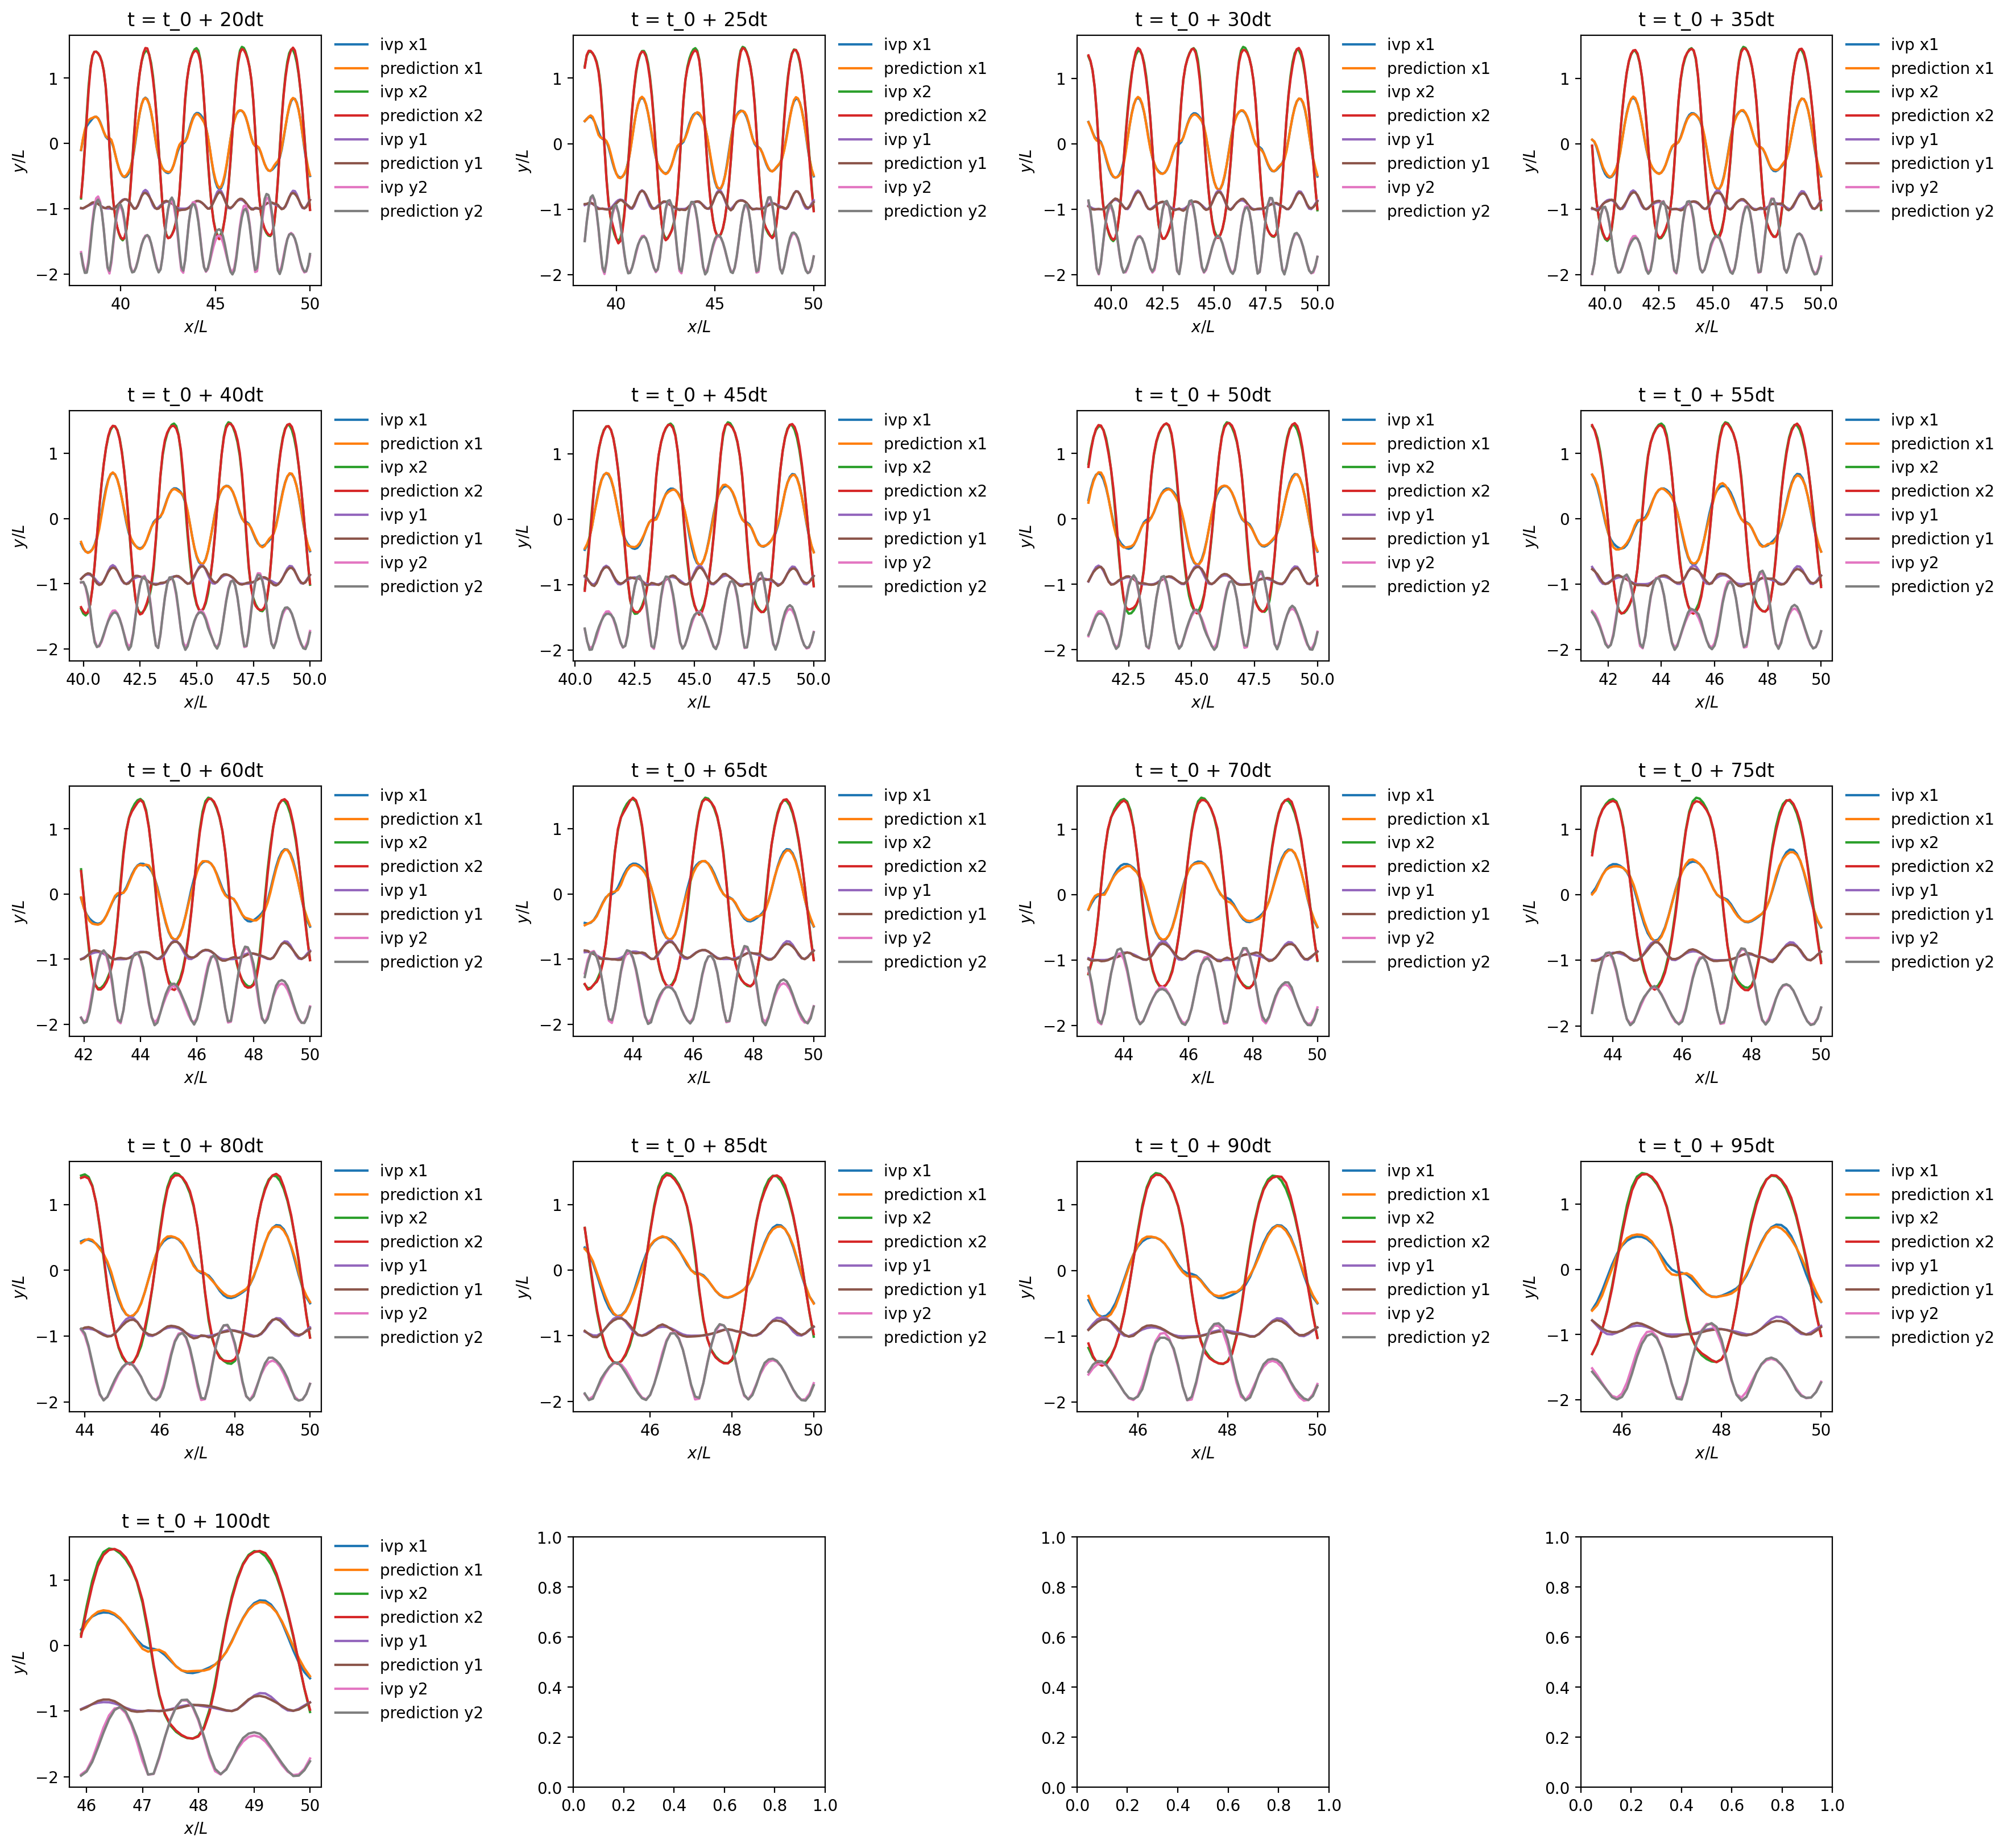

In [ ]:
#Plot predictions across given range of offsets
offsets = np.arange(20,101,5)
test_costs = OffsetsPlotCost(data,offsets,model)

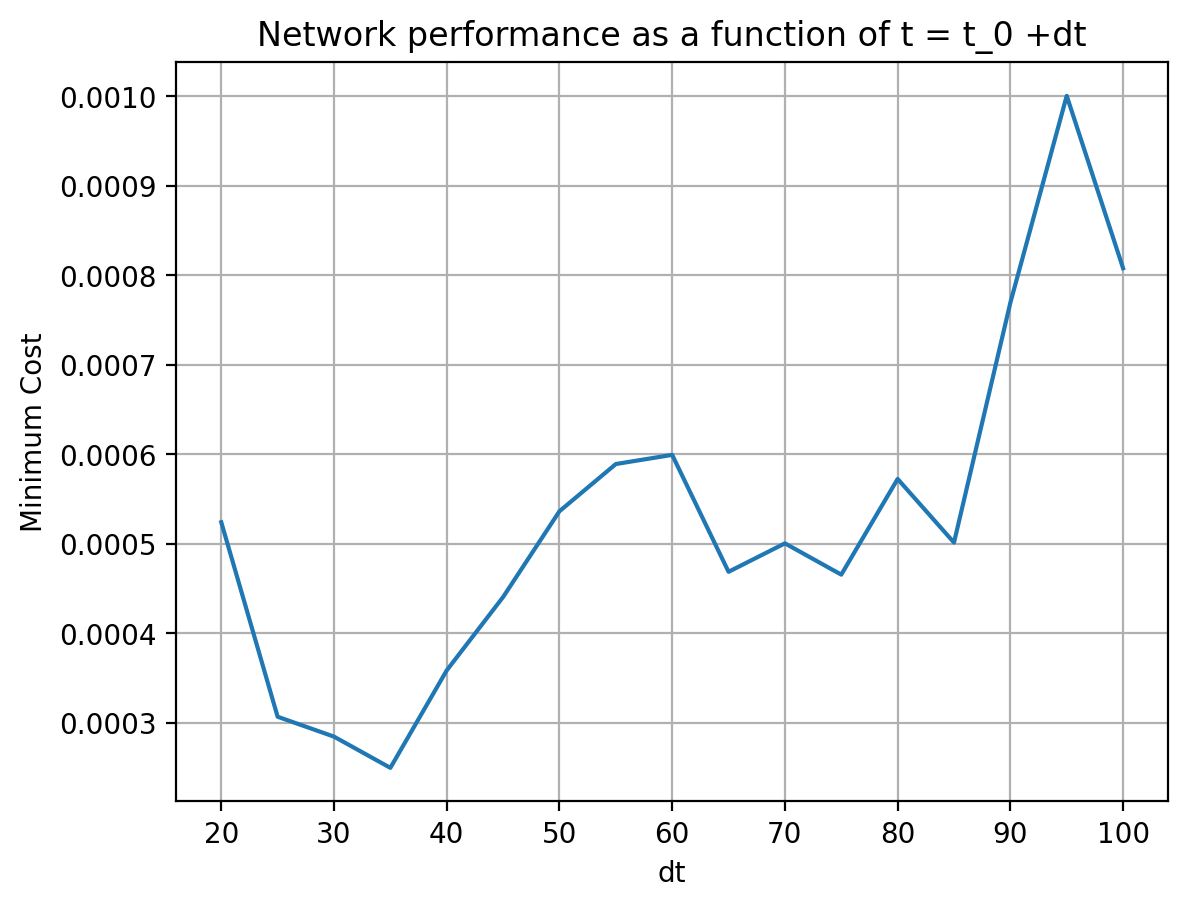

In [ ]:
#Plot minimum cost point against offset
offsets = np.arange(20,101,5)

fig,ax=plt.subplots()
ax.plot(offsets,test_costs,label=r"Costs")
ax.set_xlabel("dt")
ax.set_ylabel("Minimum Cost")
ax.set_title("Network performance as a function of t = t_0 +dt")
plt.grid(True)

#Part 4

In [ ]:
#New initial conditions for w_0 = pi/2

#Starting angles
z0_pi2=[np.pi/2,0,np.pi/2,0] # theta 1, w1, theta 2, w2

#Solve ivp
ret2 = solve_ivp(rhs, (0,tmax), z0_pi2, t_eval=t, args=(L1, L2, m1, m2, g))
z_pi2=ret2.y

#Extract result
x1_pi2,x2_pi2,y1_pi2,y2_pi2 = extract_data(z_pi2)
data_pi2 = np.array([x1_pi2,x2_pi2,y1_pi2,y2_pi2])

In [ ]:
#Train model
params_pi2 =  modelparams(data_pi2,30,20) #Windowsize 30

history = model.fit(params_pi2[0],params_pi2[1],batch_size=20,epochs=200,verbose = 1,validation_data=(params_pi2[2], params_pi2[3]))

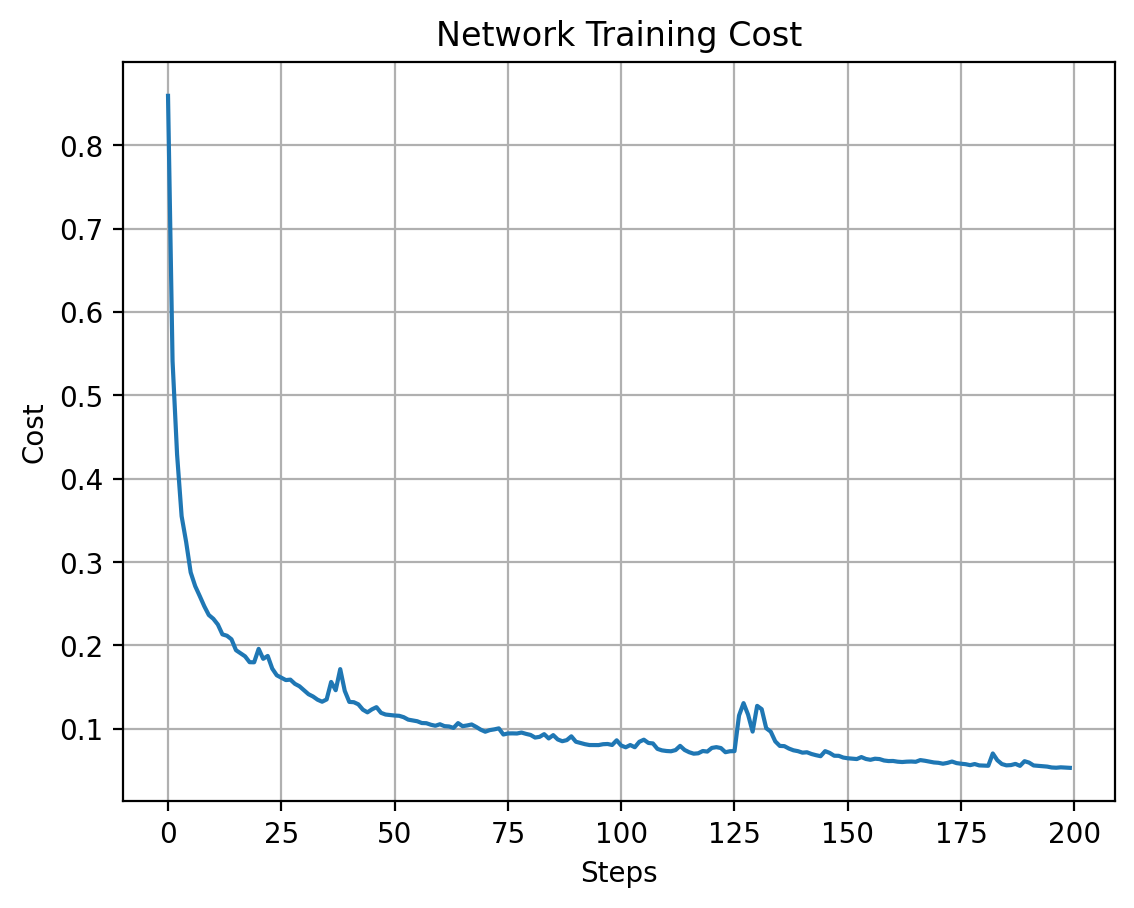

In [ ]:
#Plot costs vs steps
steps = 200
fig,ax=plt.subplots()
ax.plot(np.arange(steps),history.history["loss"],label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
plt.grid(True)

4/4 [==============================] - 0s 4ms/step


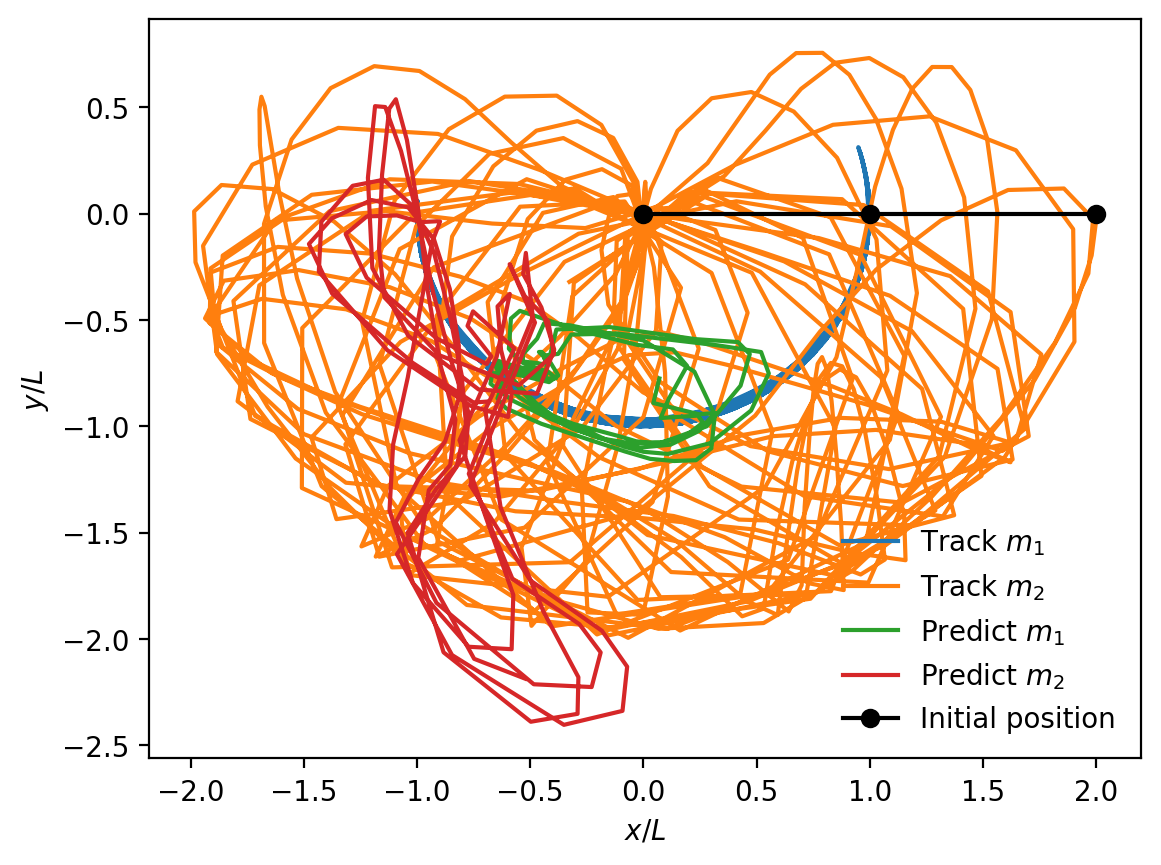

In [ ]:
#Predicted plot data
px1_pi2,px2_pi2,py1_pi2,py2_pi2 = prediction_data(params[2],model)

#Plot the actual and predicted values
fig,ax=plt.subplots()
ax.plot(x1_pi2, y1_pi2, label=r"Track $m_1$")
ax.plot(x2_pi2, y2_pi2, label=r"Track $m_2$")

ax.plot(px1_pi2, py1_pi2, label=r"Predict $m_1$")
ax.plot(px2_pi2, py2_pi2, label=r"Predict $m_2$")

ax.plot([0, x1_pi2[0], x2_pi2[0]], [0, y1_pi2[0], y2_pi2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [ ]:
offsets = np.arange(20,101,5)
test_costs_pi2 = OffsetsPlotCost(data_pi2,offsets,model)

Output hidden; open in https://colab.research.google.com to view.

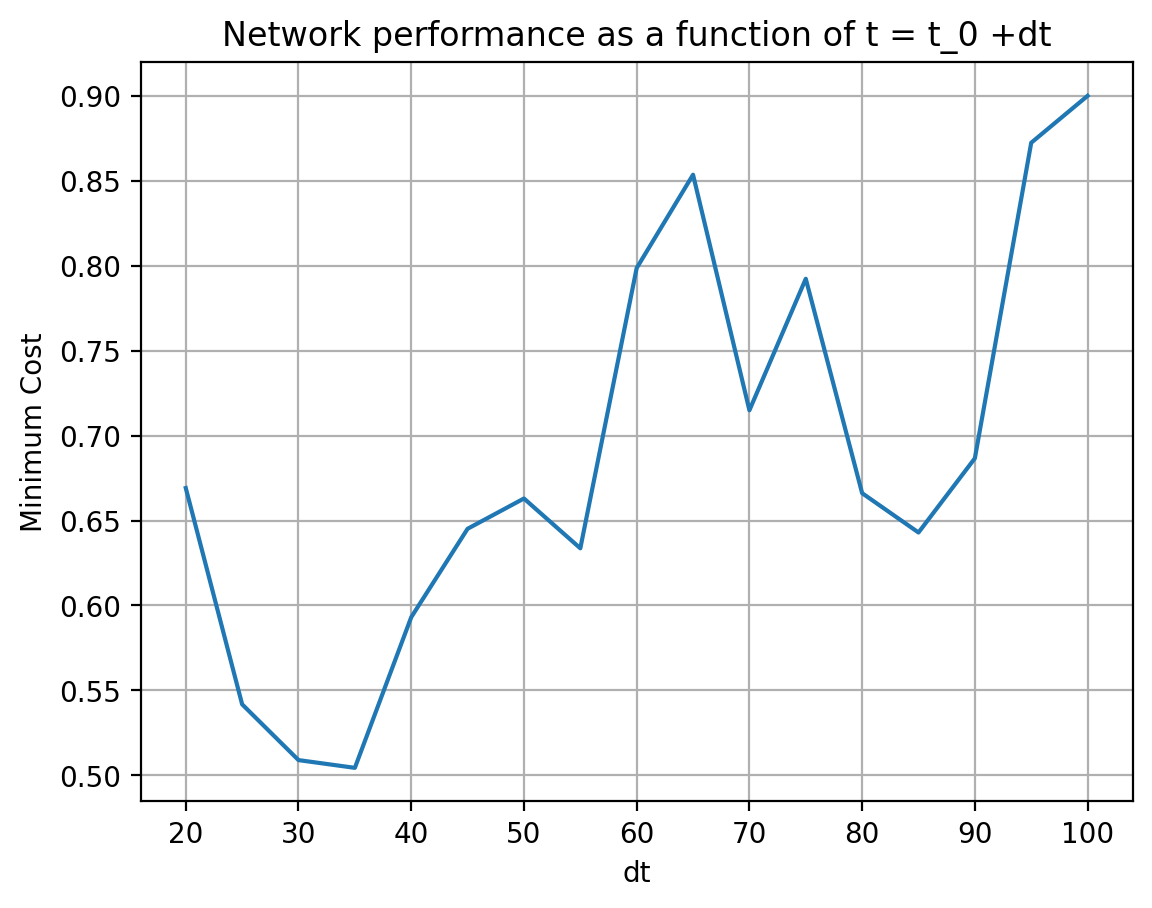

In [ ]:
#Plot minimum cost point against offset
fig,ax=plt.subplots()
ax.plot(offsets,test_costs_pi2,label=r"Costs")
ax.set_xlabel("dt")
ax.set_ylabel("Minimum Cost")
ax.set_title("Network performance as a function of t = t_0 +dt")
plt.grid(True)

#Part 5.1

In [ ]:
def modelparams_m2(data,windowsize,offset):
  '''
  Takes in data points and returns training and validation params for given windowsizer and offset
  omitted m1 positions for this training set
  '''

  #Split data intro training and validation parts
  split = int(len(data[0])*0.7)

  train_data = np.array([data[1][0:split],data[3][0:split]]).T
  test_data = np.array([data[1][split:-1],data[3][split:-1]]).T

  #Shape test and training arrays
  train_dataInput,train_dataLabel = shapeArray(train_data,windowsize,offset)
  test_dataInput,test_dataLabel = shapeArray(test_data,windowsize,offset)

  # Get target data
  train_data_target = train_dataLabel[:, -1].reshape(train_dataLabel.shape[0], 2)
  test_data_target = test_dataLabel[:, -1].reshape(test_dataLabel.shape[0], 2)

  return(train_dataInput,train_data_target,test_dataInput,test_data_target)

#Define model for just two points
model_m2=keras.models.Sequential()
model_m2.add(keras.layers.LSTM(20,input_shape=(None,2),return_sequences=False)) # LSTM layer 20 nodes
model_m2.add(keras.layers.Dense(2,activation="linear"))
model_m2.compile(loss='mean_squared_error',optimizer='adam')
model_m2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                1840      
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 1882 (7.35 KB)
Trainable params: 1882 (7.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Train model
params =  modelparams_m2(data,10,20)

history = model_m2.fit(params[0],params[1],batch_size=20,epochs=200,verbose = 1,validation_data=(params[2], params[3]))

4/4 [==============================] - 0s 5ms/step


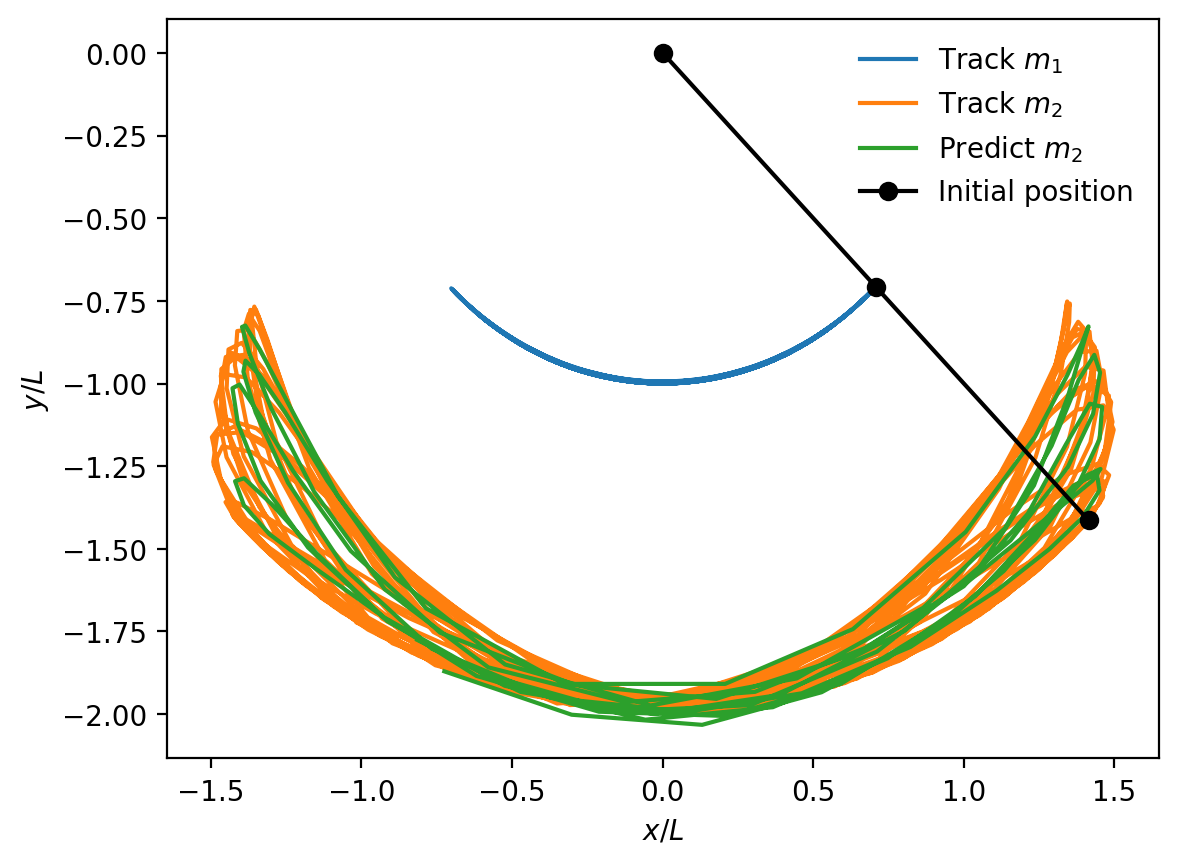

In [ ]:
#Plot predictive data over test range
def prediction_data_m2(test_data,model):
  #Makes a prediction over test data
  predictions = model.predict(test_data)
  px2 = predictions[:,0]
  py2 = predictions[:,1]

  return(px2,py2)

px2_m2,py2_m2 = prediction_data_m2(params[2],model2)

# Plot the actual and predicted values
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")

ax.plot(px2_m2, py2_m2, label=r"Predict $m_2$")

ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [ ]:
def OffsetsPlotCost_m2(data,offsets,modell):
  'Retrains and plots prediction and ivp data components over test range for series of offsets. returns minimum cost point for each offset'

  #Setup trackers
  index = 0
  test_costs = []

  #Setup subplots
  fig, axs = plt.subplots(nrows = 5,ncols = 4,figsize = (20,20))
  plt.subplots_adjust(hspace=0.5)
  plt.subplots_adjust(wspace=1)

  figs =((0,0),(0,1),(0,2),(0,3),
        (1,0),(1,1),(1,2),(1,3),
        (2,0),(2,1),(2,2),(2,3),
        (3,0),(3,1),(3,2),(3,3),
        (4,0))

  for i in offsets:

    ##### Reset and train model
    model=modell
    params =  modelparams_m2(data,10,offsets[index]) #Windowsize 10
    history = model.fit(params[0],params[1],batch_size=20,epochs=200,verbose = 0,validation_data=(params[2], params[3]))

    ##### Plot difference betwen predictive data against ivp soultion
    px2,py2 = prediction_data_m2(params[2],modell)

    print(figs[0])
    # Plot the actual vs predicted values
    axs[figs[index]].plot(t[-len(px2):],x1[-len(px2):],label=('ivp x1'))
    axs[figs[index]].plot(t[-len(px2):],x2[-len(px2):],label=('ivp x2'))
    axs[figs[index]].plot(t[-len(px2):],px2,label=('prediction x2'))
    axs[figs[index]].plot(t[-len(px2):],y1[-len(px2):],label=('ivp y1'))
    axs[figs[index]].plot(t[-len(px2):],y2[-len(px2):],label=('ivp y2'))
    axs[figs[index]].plot(t[-len(px2):],py2,label=('prediction y2'))

    axs[figs[index]].set_ylabel(r"$y/L$")
    axs[figs[index]].set_xlabel(r"$x/L$")
    axs[figs[index]].set_title(f"t = t_0 + {i}dt")
    axs[figs[index]].legend(bbox_to_anchor=(1, 1.05))

    index += 1
    test_costs.append(min(history.history["val_loss"]))
  return(test_costs)

4/4 [==============================] - 0s 8ms/step
(0, 0)
4/4 [==============================] - 0s 6ms/step
(0, 0)
4/4 [==============================] - 0s 6ms/step
(0, 0)
4/4 [==============================] - 0s 7ms/step
(0, 0)
4/4 [==============================] - 0s 7ms/step
(0, 0)
3/3 [==============================] - 0s 5ms/step
(0, 0)
3/3 [==============================] - 0s 9ms/step
(0, 0)
3/3 [==============================] - 0s 6ms/step
(0, 0)
3/3 [==============================] - 0s 5ms/step
(0, 0)
3/3 [==============================] - 0s 6ms/step
(0, 0)
3/3 [==============================] - 0s 5ms/step
(0, 0)
3/3 [==============================] - 0s 6ms/step
(0, 0)
2/2 [==============================] - 0s 7ms/step
(0, 0)
2/2 [==============================] - 0s 17ms/step
(0, 0)
2/2 [==============================] - 0s 9ms/step
(0, 0)
2/2 [==============================] - 0s 8ms/step
(0, 0)
2/2 [==============================] - 0s 9ms/step
(0, 0)


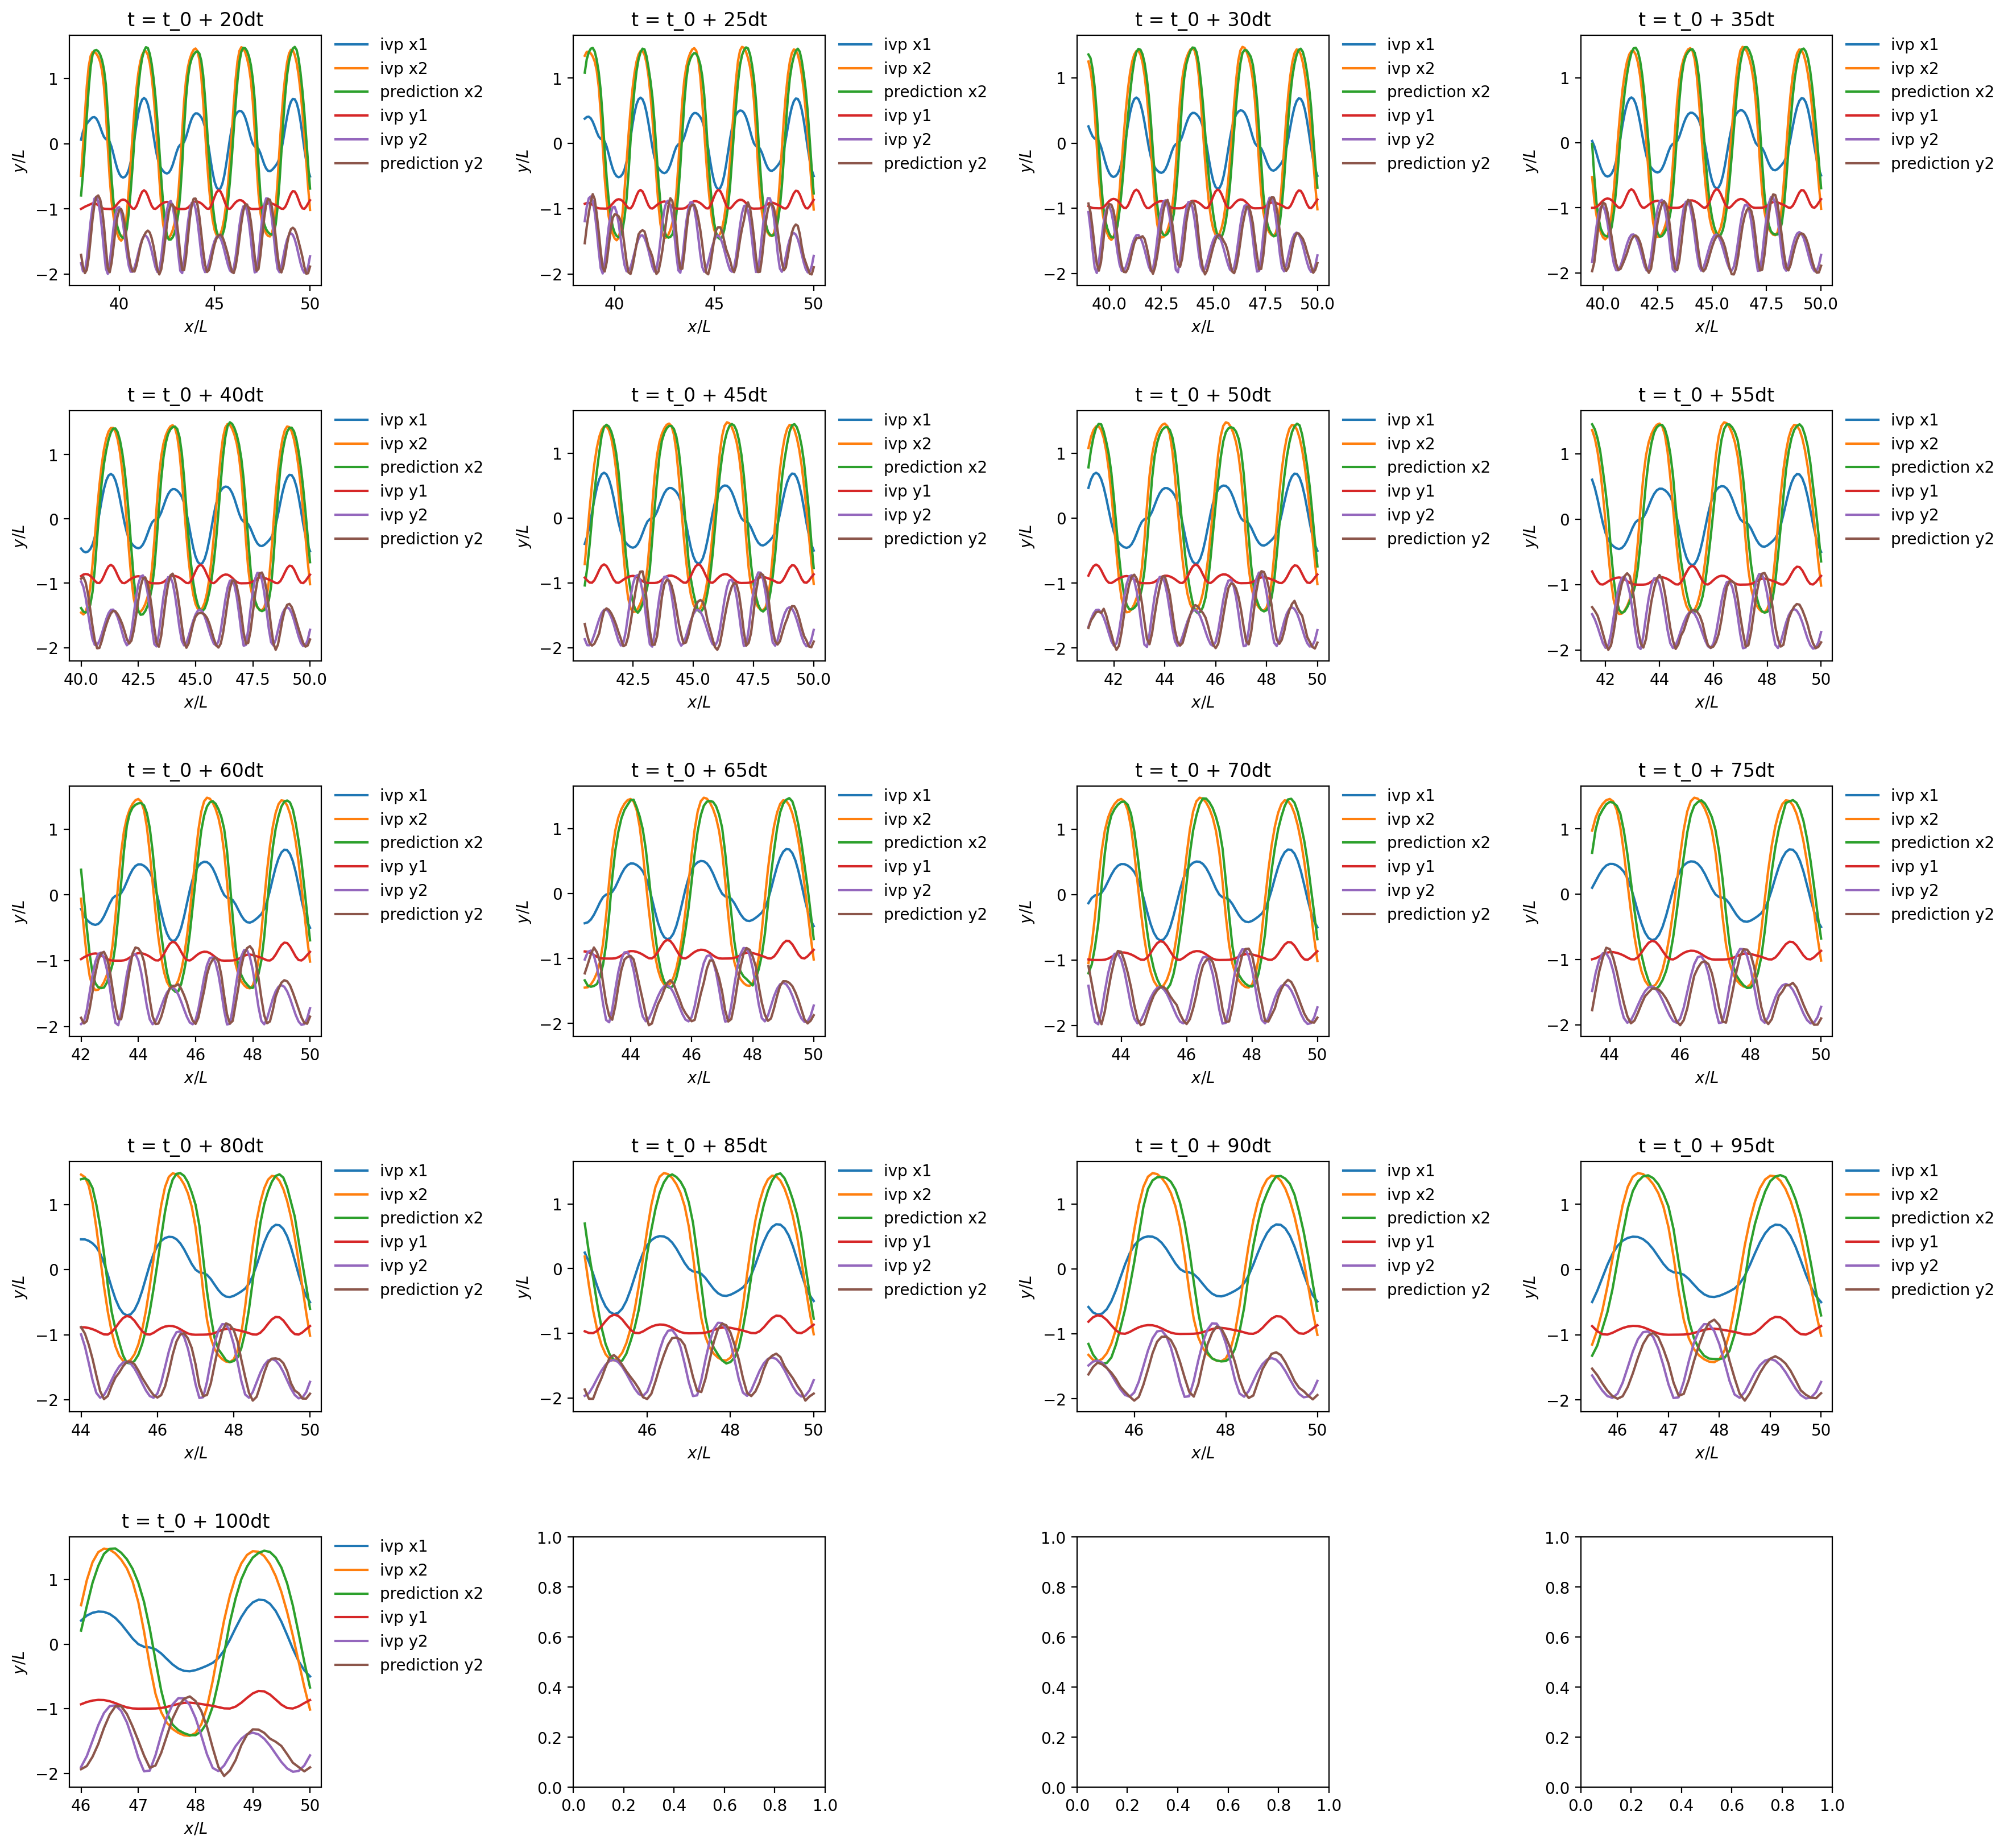

In [ ]:
#Plot predictions across given range of offsets
offsets = np.arange(20,101,5)
test_costs_m2 = OffsetsPlotCost_m2(data,offsets,model_m2)

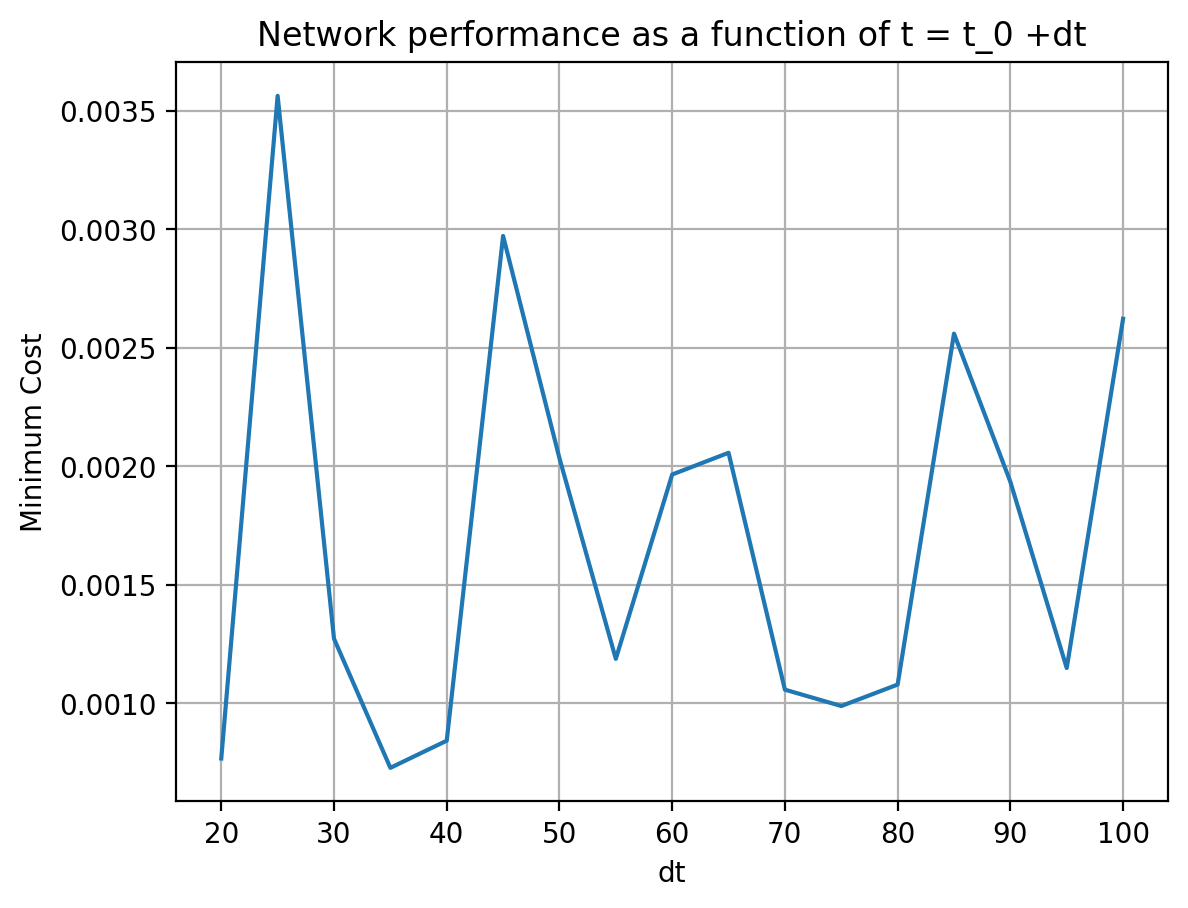

In [ ]:
#Plot minimum cost point against offset
fig,ax=plt.subplots()
ax.plot(offsets,test_costs_m2,label=r"Costs")
ax.set_xlabel("dt")
ax.set_ylabel("Minimum Cost")
ax.set_title("Network performance as a function of t = t_0 +dt")
plt.grid(True)

#Part 5.2

In [ ]:
#Train pi/2 model on m2 only
params_pi2_m2 =  modelparams_m2(data_pi2,30,20) #Windowsize 30

history = model.fit(params_pi2_m2[0],params_pi2_m2[1],batch_size=20,epochs=200,verbose = 1,validation_data=(params_pi2_m2[2], params_pi2_m2[3]))

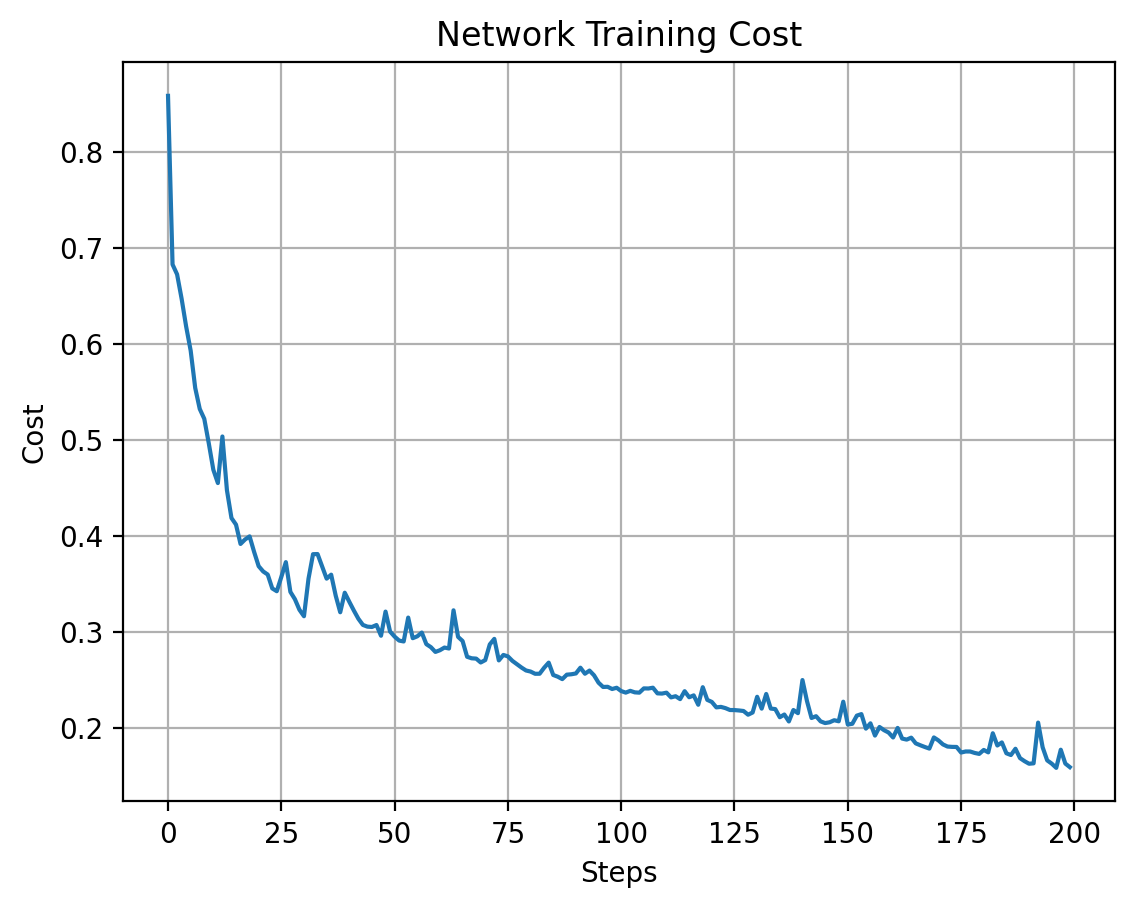

In [ ]:
#Plot costs vs steps
steps = 200
fig,ax=plt.subplots()
ax.plot(np.arange(steps),history.history["loss"],label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
plt.grid(True)

4/4 [==============================] - 0s 8ms/step


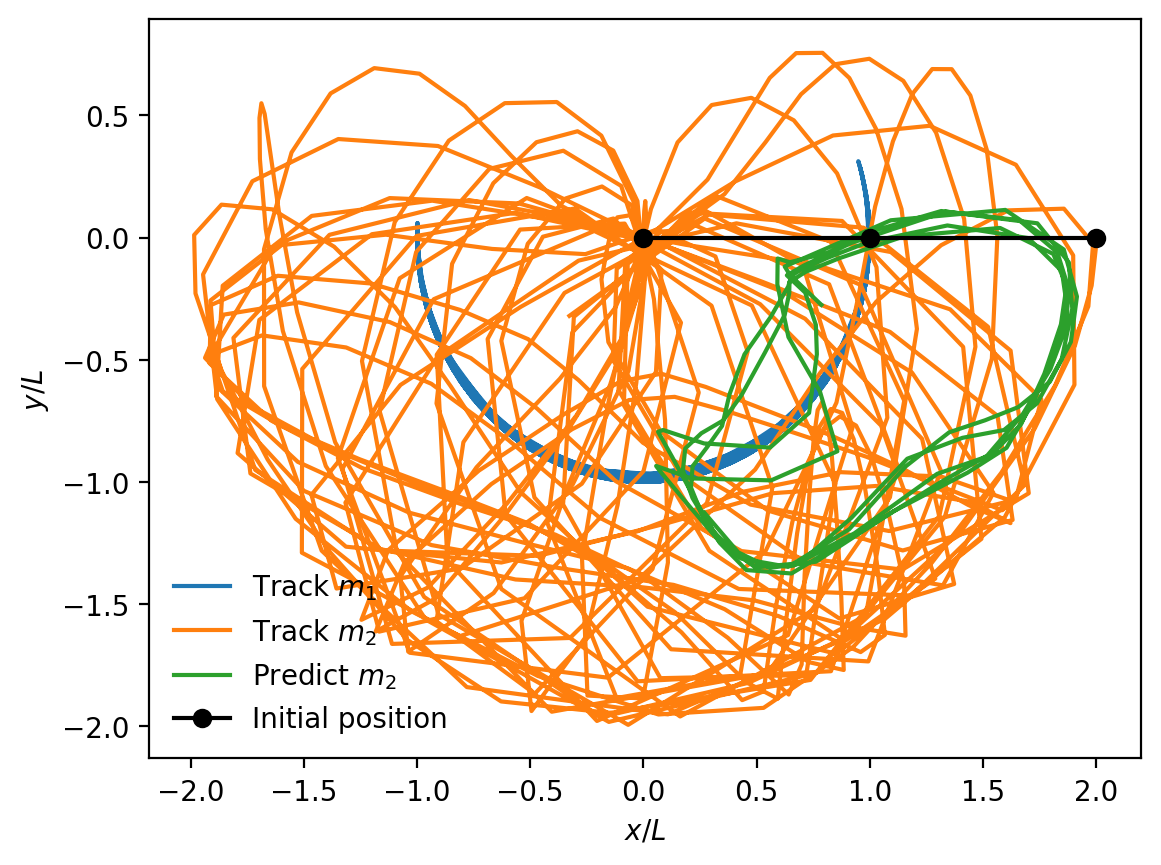

In [ ]:
#Predicted plot data
px2_pi2_m2,py2_pi2_m2 = prediction_data_m2(params[2],model_m2)

#Plot the actual and predicted values
fig,ax=plt.subplots()
ax.plot(x1_pi2, y1_pi2, label=r"Track $m_1$")
ax.plot(x2_pi2, y2_pi2, label=r"Track $m_2$")

ax.plot(px2_pi2_m2, py2_pi2_m2, label=r"Predict $m_2$")

ax.plot([0, x1_pi2[0], x2_pi2[0]], [0, y1_pi2[0], y2_pi2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [ ]:
offsets = np.arange(20,101,5)
test_costs_pi2_m2 = OffsetsPlotCost_m2(data_pi2,offsets,model_m2)

Output hidden; open in https://colab.research.google.com to view.

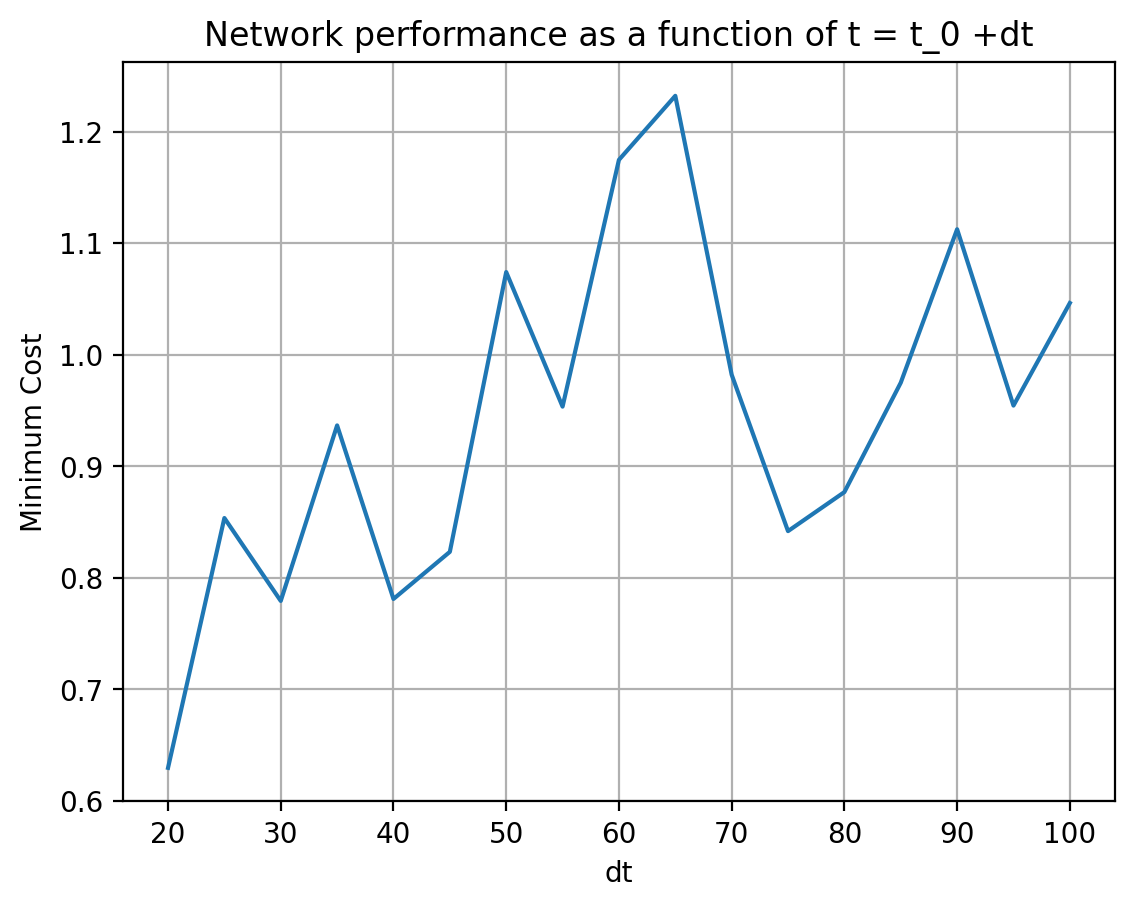

In [ ]:
#Plot minimum cost point against offset
fig,ax=plt.subplots()
ax.plot(offsets,test_costs_pi2_m2,label=r"Costs")
ax.set_xlabel("dt")
ax.set_ylabel("Minimum Cost")
ax.set_title("Network performance as a function of t = t_0 +dt")
plt.grid(True)